In [1]:
import polars as pl
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
DATA_FOLDER = "nyc_data"
all_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "**/*.parquet")))

print(f"Found {len(all_files)} files.")

if len(all_files) == 0:
    print("No files found! Check your folder path.")
else:
    print(all_files)

Found 119 files.
['nyc_data/2016/yellow_tripdata_2016-01.parquet', 'nyc_data/2016/yellow_tripdata_2016-02.parquet', 'nyc_data/2016/yellow_tripdata_2016-03.parquet', 'nyc_data/2016/yellow_tripdata_2016-04.parquet', 'nyc_data/2016/yellow_tripdata_2016-05.parquet', 'nyc_data/2016/yellow_tripdata_2016-06.parquet', 'nyc_data/2016/yellow_tripdata_2016-07.parquet', 'nyc_data/2016/yellow_tripdata_2016-08.parquet', 'nyc_data/2016/yellow_tripdata_2016-09.parquet', 'nyc_data/2016/yellow_tripdata_2016-10.parquet', 'nyc_data/2016/yellow_tripdata_2016-11.parquet', 'nyc_data/2016/yellow_tripdata_2016-12.parquet', 'nyc_data/2017/yellow_tripdata_2017-01.parquet', 'nyc_data/2017/yellow_tripdata_2017-02.parquet', 'nyc_data/2017/yellow_tripdata_2017-03.parquet', 'nyc_data/2017/yellow_tripdata_2017-04.parquet', 'nyc_data/2017/yellow_tripdata_2017-05.parquet', 'nyc_data/2017/yellow_tripdata_2017-06.parquet', 'nyc_data/2017/yellow_tripdata_2017-07.parquet', 'nyc_data/2017/yellow_tripdata_2017-08.parquet', 'n

In [3]:
FARES_FILE = "extra_data/fares.csv"
ZONES_FILE = "extra_data/zones.csv"

fares_df = pl.read_csv(FARES_FILE)
zones_df = pl.read_csv(ZONES_FILE)

fares_df.head()
zones_df.head()

LocationID,Borough,Zone,service_zone
i64,str,str,str
1,"""EWR""","""Newark Airport""","""EWR"""
2,"""Queens""","""Jamaica Bay""","""Boro Zone"""
3,"""Bronx""","""Allerton/Pelham Gardens""","""Boro Zone"""
4,"""Manhattan""","""Alphabet City""","""Yellow Zone"""
5,"""Staten Island""","""Arden Heights""","""Boro Zone"""


In [5]:
file_str = "2024"
files_2024 = [f for f in all_files if file_str in f]
lf = pl.scan_parquet(files_2024)
lf.schema

/tmp/ipykernel_22571/1894139072.py:4: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  lf.schema


Schema([('VendorID', Int32),
        ('tpep_pickup_datetime', Datetime(time_unit='ns', time_zone=None)),
        ('tpep_dropoff_datetime', Datetime(time_unit='ns', time_zone=None)),
        ('passenger_count', Int64),
        ('trip_distance', Float64),
        ('RatecodeID', Int64),
        ('store_and_fwd_flag', String),
        ('PULocationID', Int32),
        ('DOLocationID', Int32),
        ('payment_type', Int64),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64),
        ('congestion_surcharge', Float64),
        ('Airport_fee', Float64)])

In [15]:
zones_pu = zones_df.rename({
    "LocationID": "PULocationID",
    "Borough": "Borough_PU",
    "Zone": "Zone_PU",
    "service_zone": "service_zone_PU"
}).lazy()

zones_do = zones_df.rename({
    "LocationID": "DOLocationID",
    "Borough": "Borough_DO",
    "Zone": "Zone_DO",
    "service_zone": "service_zone_DO"
}).lazy()

lf_geo = (
    lf
    .join(zones_pu, on="PULocationID", how="left")
    .join(zones_do, on="DOLocationID", how="left")
)

#lf_geo.schema

In [ ]:
NYC_BOROUGHS = [
    "Manhattan",
    "Brooklyn",
    "Queens",
    "Bronx",
    "Staten Island",
]

borough_colors = {
    "Manhattan": "#1f77b4",
    "Brooklyn": "#ff7f0e",
    "Queens": "#2ca02c",
    "Bronx": "#d62728",
    "Staten Island": "#9467bd",
}

lf_enriched = (
    lf_geo
    .drop(["tpep_pickup_datetime", "tpep_dropoff_datetime"])
    .filter(
        (pl.col("trip_distance") > 0) &
        (pl.col("fare_amount") > 0)
    )
    .filter(
        pl.col("Borough_PU").is_in(NYC_BOROUGHS) &
        pl.col("Borough_DO").is_in(NYC_BOROUGHS)
    )
    .with_columns([
        (pl.col("fare_amount") / pl.col("trip_distance"))
            .alias("fare_per_mile"),
        (pl.col("total_amount") / pl.col("trip_distance"))
            .alias("total_per_mile"),
        (pl.col("tip_amount") / pl.col("trip_distance"))
            .alias("tip_per_mile"),
    ])
)
#lf_enriched.schema

In [17]:
pu_zone_stats = (
    lf_enriched
    .group_by("Zone_PU")
    .agg([
        pl.first("Borough_PU").alias("Borough_PU"),
        pl.len().alias("n_trips"),
        pl.mean("fare_per_mile").alias("avg_fare_per_mile"),
        pl.median("fare_per_mile").alias("med_fare_per_mile"),
        pl.mean("tip_per_mile").alias("avg_tip_per_mile"),
        pl.median("tip_per_mile").alias("med_tip_per_mile"),
    ])
    .filter(pl.col("n_trips") > 10) # stability threshold
    .sort("med_fare_per_mile", descending=True)
    .collect()
)

do_zone_stats = (
    lf_enriched
    .group_by("Zone_DO")
    .agg([
        pl.first("Borough_DO").alias("Borough_DO"),
        pl.len().alias("n_trips"),
        pl.mean("fare_per_mile").alias("avg_fare_per_mile"),
        pl.median("fare_per_mile").alias("med_fare_per_mile"),
        pl.mean("tip_per_mile").alias("avg_tip_per_mile"),
        pl.median("tip_per_mile").alias("med_tip_per_mile"),
    ])
    .filter(pl.col("n_trips") > 10)
    .sort("med_fare_per_mile", descending=True)
    .collect()
)

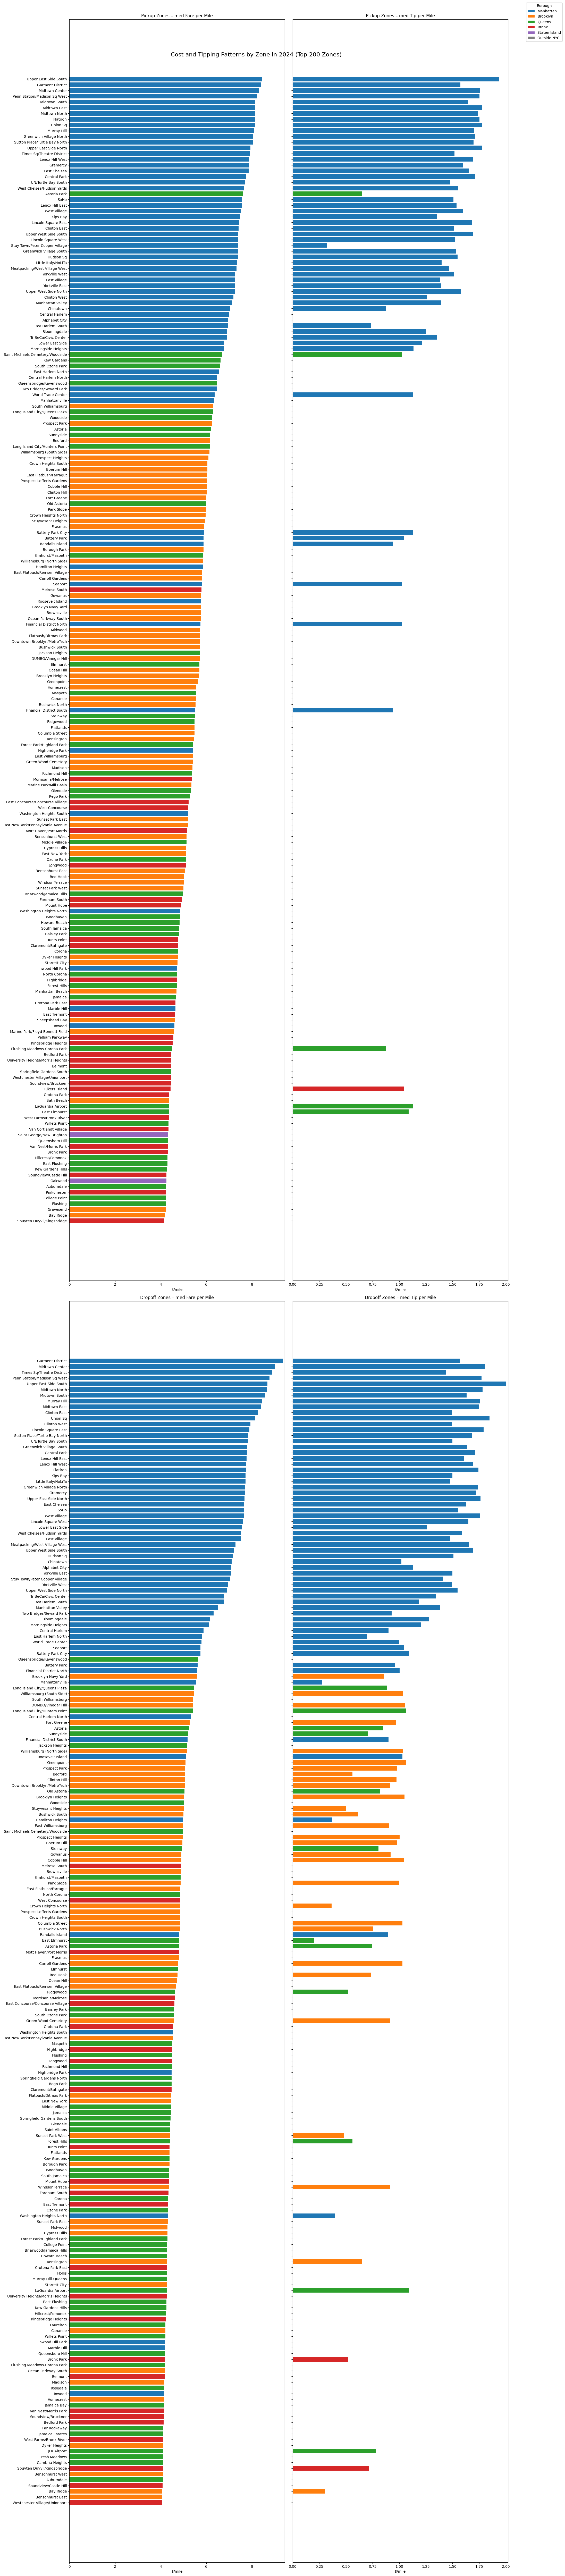

In [ ]:
COUNT = 200
FARE = "med"
TIP = "med"

pu_top = pu_zone_stats.slice(0, COUNT)
do_top = do_zone_stats.slice(0, COUNT)

pu_zones = pu_top["Zone_PU"].to_list()
pu_fare = pu_top[f"{FARE}_fare_per_mile"].to_list()
pu_tip = pu_top[f"{TIP}_tip_per_mile"].to_list()
pu_boroughs = pu_top["Borough_PU"].to_list()

do_zones = do_top["Zone_DO"].to_list()
do_fare = do_top[f"{FARE}_fare_per_mile"].to_list()
do_tip = do_top[f"{TIP}_tip_per_mile"].to_list()
do_boroughs = do_top["Borough_DO"].to_list()

pu_colors = [borough_colors.get(b, "#7f7f7f") for b in pu_boroughs]
do_colors = [borough_colors.get(b, "#7f7f7f") for b in do_boroughs]

fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(20, COUNT // 2),
    sharey="row"
)

axs[0, 0].barh(pu_zones, pu_fare, color=pu_colors)
axs[0, 0].set_title(f"Pickup Zones – {FARE} Fare per Mile")
axs[0, 0].set_xlabel("$/mile")
axs[0, 0].invert_yaxis()

axs[0, 1].barh(pu_zones, pu_tip, color=pu_colors)
axs[0, 1].set_title(f"Pickup Zones – {TIP} Tip per Mile")
axs[0, 1].set_xlabel("$/mile")

axs[1, 0].barh(do_zones, do_fare, color=do_colors)
axs[1, 0].set_title(f"Dropoff Zones – {FARE} Fare per Mile")
axs[1, 0].set_xlabel("$/mile")
axs[1, 0].invert_yaxis()

axs[1, 1].barh(do_zones, do_tip, color=do_colors)
axs[1, 1].set_title(f"Dropoff Zones – {TIP} Tip per Mile")
axs[1, 1].set_xlabel("$/mile")

# Limits
fare_max = max(max(pu_fare), max(do_fare))
tip_max = max(max(pu_tip), max(do_tip))

axs[0, 0].set_xlim(0, fare_max * 1.01)
axs[1, 0].set_xlim(0, fare_max * 1.01)

axs[0, 1].set_xlim(0, tip_max * 1.01)
axs[1, 1].set_xlim(0, tip_max * 1.01)

legend_elements = [Patch(facecolor=color, label=boro) for boro, color in borough_colors.items()]

fig.legend(
    handles=legend_elements,
    title="Borough",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

fig.suptitle(
    f"Cost and Tipping Patterns by Zone in {file_str} (Top {COUNT} Zones)",
    fontsize=16
)

plt.tight_layout()
plt.show()

In [26]:
print(lf_enriched.schema)

print(
    lf_enriched
    .select(["fare_amount", "tip_amount", "trip_distance", "Zone_PU", "Zone_DO", "fare_per_mile", "tip_per_mile"])
    .sort("tip_per_mile", descending=True) 
    .limit(50)
    .collect()
)

/tmp/ipykernel_22571/136407439.py:3: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  print(lf_enriched.schema)


Schema({'VendorID': Int32, 'passenger_count': Int64, 'trip_distance': Float64, 'RatecodeID': Int64, 'store_and_fwd_flag': String, 'PULocationID': Int32, 'DOLocationID': Int32, 'payment_type': Int64, 'fare_amount': Float64, 'extra': Float64, 'mta_tax': Float64, 'tip_amount': Float64, 'tolls_amount': Float64, 'improvement_surcharge': Float64, 'total_amount': Float64, 'congestion_surcharge': Float64, 'Airport_fee': Float64, 'Borough_PU': String, 'Zone_PU': String, 'service_zone_PU': String, 'Borough_DO': String, 'Zone_DO': String, 'service_zone_DO': String, 'fare_per_mile': Float64, 'total_per_mile': Float64, 'tip_per_mile': Float64})
shape: (50, 7)
┌─────────────┬────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┐
│ fare_amount ┆ tip_amount ┆ trip_distanc ┆ Zone_PU      ┆ Zone_DO     ┆ fare_per_mi ┆ tip_per_mil │
│ ---         ┆ ---        ┆ e            ┆ ---          ┆ ---         ┆ le          ┆ e           │
│ f64         ┆ f64        ┆ ---          

In [28]:
pu_borough_stats = (
    lf_enriched
    .group_by("Borough_PU")
    .agg([
        pl.len().alias("n_trips"),
        pl.mean("fare_per_mile").alias("avg_fare_per_mile"),
        pl.median("fare_per_mile").alias("med_fare_per_mile"),
        pl.mean("tip_per_mile").alias("avg_tip_per_mile"),
        pl.median("tip_per_mile").alias("med_tip_per_mile"),
    ])
    .sort("med_fare_per_mile", descending=True)
    .collect()
)

do_borough_stats = (
    lf_enriched
    .group_by("Borough_DO")
    .agg([
        pl.len().alias("n_trips"),
        pl.mean("fare_per_mile").alias("avg_fare_per_mile"),
        pl.median("fare_per_mile").alias("med_fare_per_mile"),
        pl.mean("tip_per_mile").alias("avg_tip_per_mile"),
        pl.median("tip_per_mile").alias("med_tip_per_mile"),
    ])
    .sort("med_fare_per_mile", descending=True)
    .collect()
)

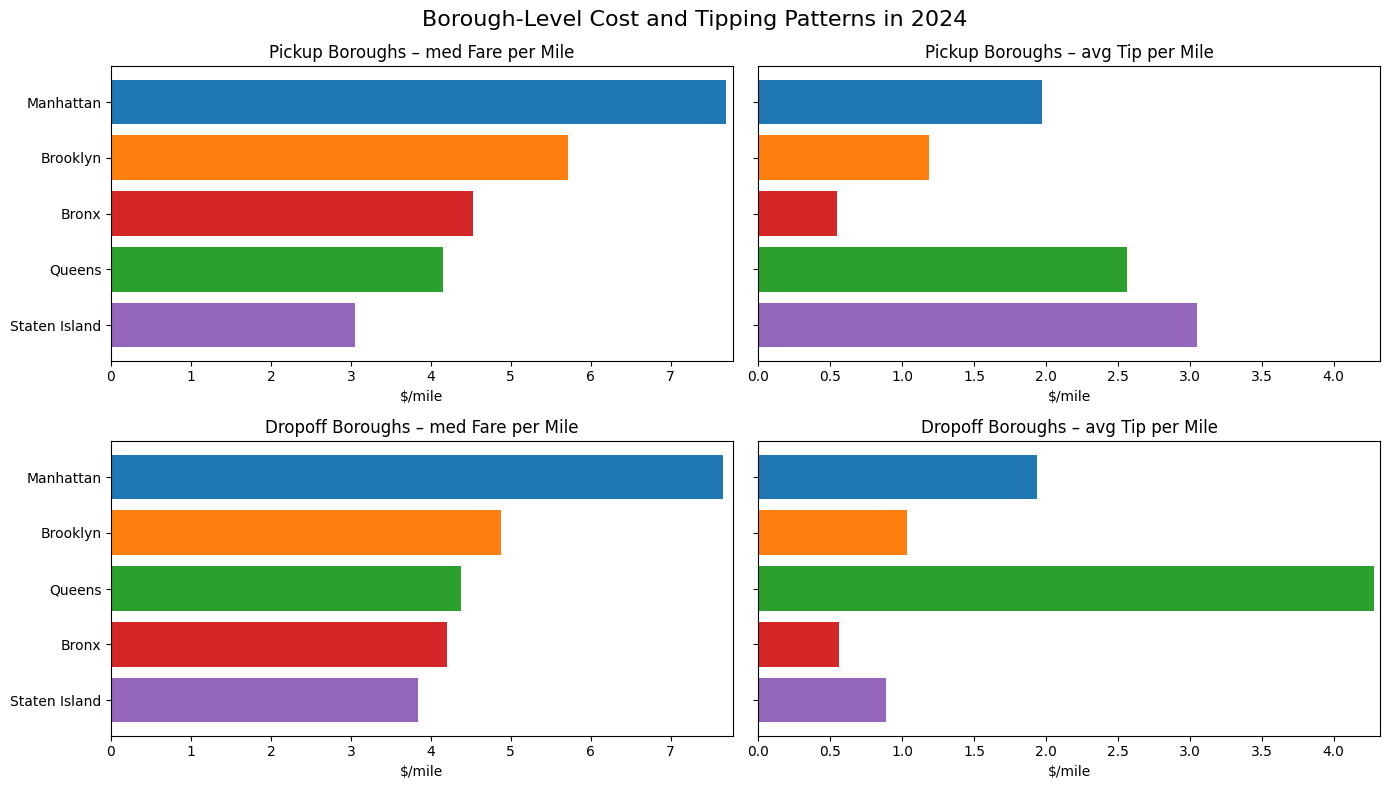

In [33]:
FARE = "med"
TIP = "avg"

pu_boros = pu_borough_stats["Borough_PU"].to_list()
pu_fare = pu_borough_stats[f"{FARE}_fare_per_mile"].to_list()
pu_tip = pu_borough_stats[f"{TIP}_tip_per_mile"].to_list()

do_boros = do_borough_stats["Borough_DO"].to_list()
do_fare = do_borough_stats[f"{FARE}_fare_per_mile"].to_list()
do_tip = do_borough_stats[f"{TIP}_tip_per_mile"].to_list()

pu_colors = [borough_colors[b] for b in pu_boros]
do_colors = [borough_colors[b] for b in do_boros]

fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(14, 8),
    sharey="row"
)

axs[0, 0].barh(pu_boros, pu_fare, color=pu_colors)
axs[0, 0].set_title(f"Pickup Boroughs – {FARE} Fare per Mile")
axs[0, 0].set_xlabel("$/mile")
axs[0, 0].invert_yaxis()

axs[0, 1].barh(pu_boros, pu_tip, color=pu_colors)
axs[0, 1].set_title(f"Pickup Boroughs – {TIP} Tip per Mile")
axs[0, 1].set_xlabel("$/mile")

axs[1, 0].barh(do_boros, do_fare, color=do_colors)
axs[1, 0].set_title(f"Dropoff Boroughs – {FARE} Fare per Mile")
axs[1, 0].set_xlabel("$/mile")
axs[1, 0].invert_yaxis()

axs[1, 1].barh(do_boros, do_tip, color=do_colors)
axs[1, 1].set_title(f"Dropoff Boroughs – {TIP} Tip per Mile")
axs[1, 1].set_xlabel("$/mile")

# Limits
fare_max = max(max(pu_fare), max(do_fare))
tip_max = max(max(pu_tip), max(do_tip))

axs[0, 0].set_xlim(0, fare_max * 1.01)
axs[1, 0].set_xlim(0, fare_max * 1.01)

axs[0, 1].set_xlim(0, tip_max * 1.01)
axs[1, 1].set_xlim(0, tip_max * 1.01)

fig.suptitle(
    f"Borough-Level Cost and Tipping Patterns in {file_str}",
    fontsize=16
)

plt.tight_layout()
plt.show()